## Introduction

In an increasingly globalized society, English is becoming more and more prevalent. This is especially true in technology driven industries, where new inventions and processes create new words that may not translate between languages. After traveling to France and interviewing people on the streets of Nantes about the use of English in the workplace, it is clear that France is no exception. People talked about how English facilitates communication because some ideas are simpler and faster to express in English. Examples of words they used included "data," "cashflow," and "roadmap." One woman working for a tech startup talked about how English can make a person seem younger since there is a generational gap in the use of English. She also talked about how everyone in tech-related industries would understand what she meant by "data," but that people outside the tech domain may not. In this notebook we explore the question: is it possible to classify French webistes as tech or non-tech based on the use of English?

## Contents

 - [Scraping the Websites](#Scraping-the-Websites)
 - [Making Features and Labels](#Making-Features-and-Labels)
 - [Visualization and Exploratory Data Analysis](#Visualization-and-Exploratory-Data-Analysis)
 - [Fitting Models](#Fitting-Models)
     - [Logistic Regression](#Logistic-Regression)
     - [SVM](#SVM)
     - [Naive Bayes](#Naive-Bayes)
 - [Conclusions](#Parametric-Modeling)

## Scraping the Websites

To answer our question, we will scrape text from the home pages of various tech and non-tech French websites.

In [1]:
import requests
from bs4 import BeautifulSoup, Comment
import nltk
import string
en_lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()
from collections import Counter
import numpy as np
import re
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import sklearn

In [2]:
# we learned how to get the visible text on a website from here:
# https://stackoverflow.com/questions/1936466/beautifulsoup-grab-visible-webpage-text?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

# returns true if an element contains visible text on a web page and false otherwise
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'meta', '[document]', 'header', 'a']:
        return False
    if isinstance(element, Comment):
        return False
    return True

# gets all the visible text on a web page
def collect_text(url):
    response_text = requests.get(url).text
    soup = BeautifulSoup(response_text,"html.parser")
    texts = soup.findAll(text=True)
    visible_texts = list(filter(tag_visible, texts))
    return visible_texts

In [3]:
# strips the text on a web page to just contain words
def clean_data(L):
    result = ""
    for word in L:
        if (word in string.whitespace) or (word in string.punctuation): continue
        word = word.lower().strip().replace("\'s", "").replace("\x92", "")
        word_no_punct = ""
        for c in word:
            if (c not in string.punctuation) and (c not in string.digits) and (c not in ["•","—", "®", "«", "»", "”", "©", "¨", "ª"]): word_no_punct += c
        result += word_no_punct + " "
    
    # tokenize
    tokenized = nltk.word_tokenize(result)
    tokenized = list(filter(lambda x: '’' not in x, tokenized))
    
    # English Lemmatize 
    en_lemmatized = list(map(lambda word: en_lemmatizer.lemmatize(word), tokenized))
    
    return en_lemmatized

## Making Features and Labels

We use the 1000 most common Enlgish words to find instances of English on the websites. After looking at various websites, we found that the 1000 most common words tend to encompass the types of English words used on these sites. What's more, the 1000 most common English words will include English stop words, the use of which is a good indicator of the website having English phrases or sentences as opposed to standalone English words.

In [4]:
#get the 1000 most common words in english
def get_words(file):
    with open(file) as f:
        words = [line.rstrip() for line in f]
    return words

english_words = get_words("1000-words.txt")

In [5]:
def make_df_and_labels(techs, non_techs):
    text_and_label = []
    for tech in techs:
        text = collect_text(tech)
        clean_text = clean_data(text)
        text_and_label += [[clean_text, 1]]
    for non_tech in non_techs:
        text = collect_text(non_tech)
        clean_text = clean_data(text)
        text_and_label += [[clean_text, 0]]
    return pd.DataFrame(text_and_label, columns = ['text', 'label'])

In [6]:
def count_english_words(text):
    #counts total english words
    count = 0
    #counts unique instances of english
    count_single = 0
    text_word_counts = Counter(text)
    for word in english_words:
        if word in text_word_counts: 
            count += text_word_counts[word]
            count_single += 1
    return count, count_single

The features we choose to add are: the total number of English words that appear on a page, which we call "eng_count," the number of unique English words on a page, which we call "eng_count_ones," and the percent of words on the page that are English, which we call "percent_total."

In [7]:
def add_english_stats(df):
    english_counts = []
    english_count_ones = []
    percent_total = []
    for text in df.text:
        eng_count, eng_count_ones = count_english_words(text)
        english_counts += [eng_count]
        english_count_ones += [eng_count_ones]
        percent_total += [eng_count/len(text)]
    df["eng_count"] = english_counts
    df["eng_count_ones"] = english_count_ones
    df["percent_total"] = percent_total
    return df

In [8]:
non_tech = ["https://www.feedsmartfood.com/fr/", 
            "https://www.neatyy.com/fr", 
            "https://velco.bike/fr/", 
            "https://ecotree.fr", 
            "https://www.lecomparateurassurance.com", 
            "http://www.lacigale.com", 
            "https://www.total.com/fr", 
            "http://www.pathe.fr/", 
            "https://www.groupe-psa.com/fr/", 
            "https://www.suez.com/fr", 
            "https://www.groupe-tf1.fr/fr", 
            "https://www.societegenerale.com/fr/accueil", 
            "https://www.bicworld.com/fr", 
            "https://www.sncf.com/fr", 
            "https://www.schneider-electric.fr/fr/", 
            "https://www.sanofi.com/fr/", 
            "https://www.salomon.com/fr/", 
            "http://www.waterman.com/fr/", 
            "https://www.veolia.fr/", 
            "https://www.vinci.com/vinci.nsf/fr/index.htm"]
tech = ["https://www.3ds.com/fr", 
        "https://qonto.eu", 
        "https://troopers.agency/fr/", 
        "https://www.arkane-studios.com/fr/index.php", 
        "https://www.atinternet.com/glossaire/frameiframe/", 
        "https://www.criteo.com/fr/", 
        "https://www.ouipharma.fr", 
        "https://www.edgemind.net/fr/examples.html", 
        "http://www.gameloft.com/fr/", 
        "https://www.gandi.net/fr", 
        "https://www.leetchi.com", 
        "http://madvertise.com/fr/appsfire/", 
        "https://health.nokia.com/ca/fr/", 
        "https://www.chauffeur-prive.com", 
        "http://www.gameloft.com/fr/", 
        "https://atos.net/fr/", 
        "http://mobile.free.fr", 
        "https://fr.360learning.com", 
        "https://www.arkane-studios.com/fr/index.php", 
        "https://www.soprasteria.com/fr/home"] 

df = make_df_and_labels(tech, non_tech)
df = add_english_stats(df)
df.head()

,text,label,eng_count,eng_count_ones,percent_total
0,"[éditeurs, de, logiciels, de, conception, d, d...",1,84,37,0.067416
1,"[qonto, compte, pro, en, ligne, pour, entrepri...",1,56,24,0.051852
2,"[trooper, agence, web, de, création, de, site,...",1,116,63,0.112950
3,"[arkane, studio, français, prey, est, disponib...",1,24,16,0.041096
4,"[frame, iframe, définition, menu, menu, mon, c...",1,14,12,0.068966


## Visualization and Exploratory Data Analysis

We begin by looking at the means and standard deviation for the features of our data for tech and non-tech sites.

In [9]:
def mean_and_std(values, length):
    print("Tech")
    print("mean: %f, standard deviation: %f" %(np.mean(values[0:length//2]), np.std(values[0:length//2])))
    print("Non-tech")
    print("mean: %f, standard deviation: %f" %(np.mean(values[length//2:]), np.std(values[length//2:])))
    print("")
    
mean_and_std(df["eng_count"], 40)
mean_and_std(df["eng_count_ones"], 40)
mean_and_std(df["percent_total"], 40)

Tech
mean: 68.300000, standard deviation: 68.673212
Non-tech
mean: 43.950000, standard deviation: 40.694564

Tech
mean: 32.700000, standard deviation: 30.853039
Non-tech
mean: 21.050000, standard deviation: 18.462056

Tech
mean: 0.092122, standard deviation: 0.080236
Non-tech
mean: 0.090230, standard deviation: 0.077841



There is a noticable difference in the means between tech and non-tech; however, we also see that they have fairly large standard deviations. This is a potential indication that these features may not be the best to use to try and classify the websites. For this reason we will create both feature based and word based classifiers. Let's now look at the most common English words on the sites.

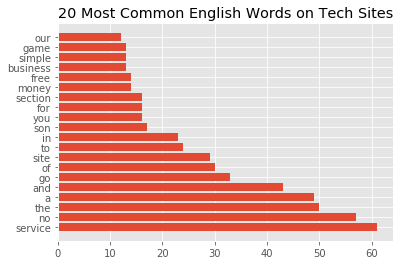

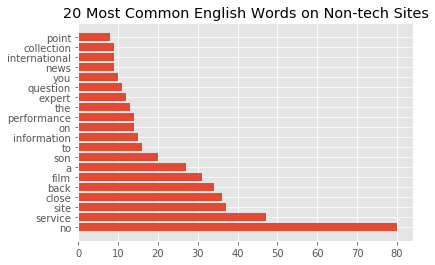

In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def make_bar_graph(text, N, title):
    counts = Counter(text)
    most_common = counts.most_common(N)
    heights = [most_common[i][1] for i in range(len(most_common))]
    x_axis = [i for i in range(N)]
    tick_label = [most_common[i][0] for i in range(len(most_common))]
    f, ax = plt.subplots()
    ax.barh(x_axis, heights, tick_label=tick_label)
    ax.set_title(title)
    plt.show()
    
def get_tech_text(english_words, length):
    tech_text = []
    for i in range(length//2):
        text = df["text"][i]
        for j in range(len(text)):
            word = text[j]
            if word in english_words:
                tech_text.append(word)
    return tech_text
            
def get_non_tech_text(english_words, length):        
    non_tech_text = []
    for i in range(length//2, length):
        text = df["text"][i]
        for j in range(len(text)):
            word = text[j]
            if word in english_words:
                non_tech_text.append(word)
    return non_tech_text

tech_text = get_tech_text(english_words, 40)
non_tech_text = get_non_tech_text(english_words, 40)
make_bar_graph(tech_text, 20, "20 Most Common English Words on Tech Sites")
make_bar_graph(non_tech_text, 20, "20 Most Common English Words on Non-tech Sites")
    

Since we see that many of the common words are also words in French, we will remove words such as "service" and "information." Now we replot the most common words so that we have words that are English and not French.

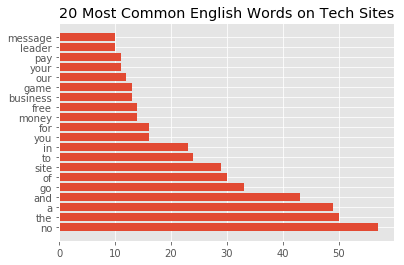

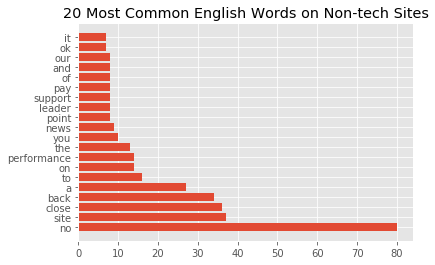

In [11]:
def remove_bad_words(words, bad_words):
    english_words = []
    for word in words:
        if word not in bad_words:
            english_words += [word]
    return english_words

bad_words = ["animal", "adult", "age", "action", "administration", "agent", "audience", "attention", 
             "billion", "capital", "central", "certain", "chance", "change", "collection", "continue", "culture", 
             "difference", "different", "direction", "education", "experience", "expert", "film", "force", "information", "institution", 
             "international", "machine", "million", "minute", "model", "moment", "notice", "operation", "option", "page", 
             "patient", "period", "place", "plan", "population", "possible", "question", "race", "region", "science", "section", "source", 
             "service", "son", "simple", "station", "total", "traditional", "type"]

english_words_no_bad = remove_bad_words(english_words, bad_words)
    
tech_text = get_tech_text(english_words_no_bad, 40)
non_tech_text = get_non_tech_text(english_words_no_bad, 40)
make_bar_graph(tech_text, 20, "20 Most Common English Words on Tech Sites")
make_bar_graph(non_tech_text, 20, "20 Most Common English Words on Non-tech Sites")

From here, we see that the most commonly used English words on French webistes in general are "no" and "a" and that tech sites use more stop words than non-tech sites, which we noted before could be an indication of using more English sentences and phrases. We can also see that the frequency of commonly used English words is lower for non-tech than tech sites. It is worth noting that the words we removed from our common English words list could have been used in either an English or a French context since they exist in both English and French. Those words could be valuable to include in our commonly used English words list if we could determine the context in which those words are used; however, this is a hard problem for another project.

## Fitting Models

We begin by fitting a feature based model.

### Logistic Regression

In [25]:
def train_test_pred_logreg(X, y, percent, verbose=False):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percent)
    lr = LogisticRegression()
    #fit the model on the training data
    lr.fit(X_train, y_train)
    #predict on the test set
    pred = lr.predict(X_test)
    if verbose:
        print(lr.predict_proba(X_test))
        print(y_test)
    #compute the accuracy
    return(np.array(y_test) == pred).mean()

train_test_pred_logreg(df[["eng_count"]], df["label"], .3, True)

[[ 0.51707722  0.48292278]
 [ 0.54726613  0.45273387]
 [ 0.31724502  0.68275498]
 [ 0.54903334  0.45096666]
 [ 0.38200163  0.61799837]
 [ 0.56838155  0.43161845]
 [ 0.56136677  0.43863323]
 [ 0.37361578  0.62638422]
 [ 0.48141733  0.51858267]
 [ 0.44770934  0.55229066]
 [ 0.29750299  0.70249701]
 [ 0.50103007  0.49896993]]
9     1
20    0
8     1
26    0
15    1
22    0
13    1
2     1
16    1
30    0
29    0
24    0
Name: label, dtype: int64


0.66666666666666663

We see that for a logistic regression with "eng_counts" it classifies fairly well; however, note that the predicted probabilities are all fairly close, which is another indication that perhaps these features are not the best way to classify. Let's first fit a few more logistic regression models and get their mean prediction accuracy, before moving on to word based classifiers.

In [48]:
def mean_accuracy(X, y, percent, tests):
    accuracies = []
    for i in range(tests):
        accuracies += [train_test_pred_logreg(X, y, percent)]
    return np.array(accuracies).mean()

#model: logit(tech) = b_0 + b_1(eng_count)
print(mean_accuracy(df[["eng_count"]], df["label"], .3, 40))

#model: logit(tech) = b_0 + b_1(eng_count_ones)
print(mean_accuracy(df[["eng_count_ones"]], df["label"], .3, 40))

#model: logit(tech) = b_0 + b_1(percent_total)
print(mean_accuracy(df[["percent_total"]], df["label"], .3, 40))

#model: logit(tech) = b_0 + b_1(eng_count) + b2(eng_count_ones) + b_3(percent_total)
print(mean_accuracy(df[["eng_count", "eng_count_ones"]], df["label"], .3, 40))

0.51875
0.527083333333
0.391666666667
0.483333333333


On average the logistic regression with "eng_counts" and "eng_count_ones" have the highest accuracies, but still do not have very high accuracies. Thus we move on to word based classifiers. 

### SVM

We chose to implement an SVM because, in case our data is not linearly separable, we can evaluate different SVM models based on different kernels to see which one does the best.

First we will randomly split our data into training and test data.

In [14]:
# We will train on 70% of our data, and test on the other 30% in general
def split_data(train_percentage, df):
    train_indices = np.random.choice(len(df), int(train_percentage*(len(df))))
    train_X = df.iloc[train_indices]
    test_indices = list(set(np.arange(len(df))) - set(train_indices))
    test_X = df.iloc[test_indices]
    return (train_X, test_X)
train_data, test_data = split_data(.7, df)

In [15]:
# Then we create feature matrices of English words for each web page in our training data
def create_features(df, english_only=True):
    text = df["text"]
    if english_only:
        def filter_text(L): return list(filter(lambda s: s in english_words_no_bad, L))
        text = text.apply(filter_text)
    strings = text.apply((" ").join)
    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(input="content", analyzer="word")
    X = tfidf.fit_transform(strings)
    
    return (tfidf, X)
tfidf, train_X = create_features(train_data, True)

From here, we test whether linear, polynomial, rbf, or sigmoid is the best kernel for our data.

In [16]:
#  Train our classifier to fit our data with different types of kernels
def train_classifier(X_train, y_train, kernel):
    classifier = sklearn.svm.classes.SVC(kernel=kernel)
    classifier.fit(X_train, y_train)
    return classifier

# And we can decide what the best kernel is
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    classifier = train_classifier(train_X, train_data["label"], kernel)
    accuracy = classifier.score(train_X, train_data["label"])
    print(kernel,':',accuracy)

linear : 1.0
rbf : 0.535714285714
poly : 0.535714285714
sigmoid : 0.535714285714


It looks like we will want to use a linear kernel in our model.

In [17]:
# Then we can classify our test data to see how we did
def classify(tfidf, classifier, test_data, english_only=True):
    text = test_data["text"]
    if english_only:
        def filter_text(L): return list(filter(lambda s: s in english_words_no_bad, L))
        text = text.apply(filter_text)
    strings = text.apply((" ").join)
    X = tfidf.transform(strings)
    return classifier.predict(X.toarray())

First, we can try running our SVM on just the English words in each text.

In [18]:
# Only English Words
accuracy = []
for i in range(20):
    train_data, test_data = split_data(.7, df)
    (tfidf, train_X) = create_features(train_data, english_only=True)
    # First we train our model
    clf = train_classifier(train_X, train_data["label"], "linear")
    # compare these predictions to the real labels
    pred = classify(tfidf, clf, test_data, english_only=True)
    accuracy.append((np.array(test_data["label"]) == pred).mean())
print(np.array(accuracy).mean())

0.436554603882


As we can see, this model does not do too well. Let's try classifying based on all of the words on a page, not just the English words, to see if the French words on a page also have impact on whether a company can be classified as tech or non-tech.

In [19]:
# English and French Words
accuracy = []
for i in range(20):
    train_data, test_data = split_data(.7, df)
    (tfidf, train_X) = create_features(train_data, english_only=False)
    # First we train our model
    clf = train_classifier(train_X, train_data["label"], "linear")
    # compare these predictions to the real labels
    pred = classify(tfidf, clf, test_data, english_only=False)
    accuracy.append((np.array(test_data["label"]) == pred).mean())
print(np.array(accuracy).mean())

0.503212378652


Even with the French words included in our model, an SVM with a linear kernel still barely does  better than guessing randomly. Let's move on to our next classifier to see if we can do better.

### Naive Bayes

Naive Bayes is a classic way to classify text. It is known to do very well on even small training data sets, which is why we thought it might be a good way to solve our problem.

We can use the same feature matrix we used for our SVM model, which uses the words found on the webpages. First, let's see how a Naive Bayes classifier does with just English words.

In [20]:
# Only English Words
accuracy = []
for i in range(20):
    train_data, test_data = split_data(.7, df)
    (tfidf, train_X) = create_features(train_data, english_only=True)
    # First we train our model
    gnb = GaussianNB()
    gnb.fit(train_X.toarray(),train_data["label"])
    # compare these predictions to the real labels
    pred = classify(tfidf, gnb, test_data, english_only=True)
    accuracy.append((np.array(test_data["label"]) == pred).mean())
print(np.array(accuracy).mean())

0.516459899749


Our Naive Bayes classifier with just English words still doesn't perform well. As we begin to lose hope that our problem is not solveable with a machine learning algorithm, we can try one last thing: a Naive Bayes classifier with English and French words.

In [49]:
# English and French words
accuracy = []
for i in range(20):
    train_data, test_data = split_data(.7, df)
    (tfidf, train_X) = create_features(train_data, english_only=False)
    # First we train our model
    gnb = GaussianNB()
    gnb.fit(train_X.toarray(),train_data["label"])
    # compare these predictions to the real labels
    pred = classify(tfidf, gnb, test_data, english_only=False)
    accuracy.append((np.array(test_data["label"]) == pred).mean())
print(np.array(accuracy).mean())

0.630657202275


Aha! This classifier actually performs pretty well! Now let's explore why this classifier did the best. 

## Conclusion

Of the three classifiers we used, the Naive Bayes classifier used on the French and English words found on a webpage performed the best. It was the only classifier that was able to consistently do better than 50%. 

The logistic regression model most likely did worse than our Naive Bayes model because it was based on the counts of English words found on a website, which contains less information than all the words. The Naive Bayes model, on the other hand, works with the words on a website. Based on this, we would conclude that the actual words found on a webpage have significant impact on whether a company is tech or non-tech.

The SVM did not perform very well either, which could be due to the fact that, while a linear kernel was the best option for separating the data of the kernels we tried, our data may not have been linearly separable to begin with.

Since our Naive Bayes classifier with both French and English words worked the best, we can see that the types of English and French words found on a webpage can be used as indicators of whether a website is tech or non-tech. The actual presence of English words on a webpage, however, may not be a strong indication of whether a company is tech or non-tech as we initially postulated.